In [1]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def unpickle(file):  
  fo = open(file, 'rb')
  dict = cPickle.load(fo)
  fo.close()
  return dict

def convert_images(vector):
    """
    Convert images from the CIFAR-10 format and
    return a 4-dim array with shape: [image_number, height, width, channel]
    where the pixels are floats between 0.0 and 1.0.
    """

    # Reshape the array to 4-dimensions.
    images = vector.reshape([3, 32, 32, -1])
    
    #images = vector.reshape([-1, 3, 32, 32])

    # Reorder the indices of the array.
    images = images.transpose([1, 2, 0, 3])
    #images = images.transpose([0, 2, 3, 1])

    return images

In [15]:
def Wstar(cov_x, cov_yx):
    if cov_x.any():
        cov_x_inv = np.linalg.pinv(cov_x)
    else:
        cov_x_inv = cov_x
    W = np.dot(cov_yx, cov_x_inv)
    return W

def mmseEstimator(x, u_x, u_y, cov_x, cov_yx):
    W = Wstar(cov_x, cov_yx)
    dist = x - u_x.reshape((u_x.shape[0]), 1)
    return np.dot(W, dist) + u_y.reshape((u_y.shape[0]), 1)

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 1])[1]
    y_idx = np.where([vectorMask == 0])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

# generates a 3072 element mask (32 x 32 x 3) with columns 
# deleted from the right side of the image towards the left
def generateColumnMask(delColumns):
    mask = np.ones((3, 32, 32))
    mask[:, :, (32 - delColumns):] = 0
    maskVec = mask.reshape(3072)
    return maskVec

def generateSquareMask(squareSideLength):
    mask = np.ones((3, 32, 32))
    leftIdx = (32 - squareSideLength)/2
    rightIdx = (32 + squareSideLength)/2
    mask[:, leftIdx:rightIdx, leftIdx:rightIdx] = 0
    maskVec = mask.reshape(3072)
    return maskVec

# let's get the data for halves for CIFAR10 data
def returnSquareData(squareSideLength):
    train, test, temp1, temp2 = returnCIFARdata()
    
    train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle = hideData(train, generateSquareMask(squareSideLength))
    test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle = hideData(test, generateSquareMask(squareSideLength))

    return train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle, test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle

# let's get the data for halves for CIFAR10 data
def returnHalfData(ncols):
    train, test, temp1, temp2 = returnCIFARdata()
    
    train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(ncols))
    test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(ncols))

    return train_hideRight, Xtrain_hideRight, Ytrain_hideRight, test_hideRight, Xtest_hideRight, Ytest_hideRight

# parse the CIFAR data files
# CIFAR10 is a 32 by 32 image with 3 color channels
def returnCIFARdata():
    train_images = np.zeros((0, 3072))
    train_labels = np.zeros(0)
    test_images = np.zeros((0, 3072))
    test_labels = np.zeros(0)

    # read in the training data
    for j in range(5):
      d = unpickle('data_batch_'+`j+1`)
      x = d['data']
      y = d['labels']
      train_images = np.concatenate((x, train_images), axis=0)
      train_labels = np.concatenate((y, train_labels))

    # read in the test data
    d = unpickle('test_batch')
    test_images = np.concatenate((test_images, d['data']), axis=0)
    test_labels = np.concatenate((test_labels, d['labels']))

    # have images in vector form
    train_images_vec = np.copy(train_images.T)/255.0
    test_images_vec = np.copy(test_images.T)/255.0

    # convert images from [3072] to [32, 32, 3]
    #train_images = convert_images(train_images)
    #test_images = convert_images(test_images)

    size = train_images_vec.shape[0]
    n_train = train_images_vec.shape[1]
    n_test = test_images_vec.shape[1]

    print '----CIFAR10 dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    return train_images_vec, test_images_vec, train_labels, test_labels
    #print train_images.shape
    #print train_labels.shape
    #print test_images.shape
    #print test_labels.shape

In [3]:
# get datasets
train, test, train_labels, test_labels = returnCIFARdata()

----CIFAR10 dataset loaded----
Train data: 3072 x 50000
Test data: 3072 x 10000


In [4]:
# define number of columns to remove
nCols = 16
vecMask = generateColumnMask(nCols)
x_idx = np.where([vecMask == 1])[1]
y_idx = np.where([vecMask == 0])[1]

# remove information
train_hideRight, Xtrain_hideRight, Ytrain_hideRight, \
test_hideRight, Xtest_hideRight, Ytest_hideRight = returnHalfData(nCols)

# do mmse estimatoin
u_x, u_y, cov_x, cov_yx = getStatistics(train, vecMask)
Ytrain_hideRight_hat = mmseEstimator(Xtrain_hideRight, u_x, u_y, cov_x, cov_yx)
Ytest_hideRight_hat = mmseEstimator(Xtest_hideRight, u_x, u_y, cov_x, cov_yx)

# calculate mse per hidden pixel for train
diff_train = Ytrain_hideRight - Ytrain_hideRight_hat
numTrain = Ytrain_hideRight.shape[1]
trainMSEs = np.zeros(numTrain)
for j in range(numTrain):
    trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
train_colMSE = np.mean(trainMSEs)

# calculate mse per hidden pixel for test
diff_test = Ytest_hideRight - Ytest_hideRight_hat
numTest = Ytest_hideRight.shape[1]
testMSEs = np.zeros(numTest)
for j in range(numTest):
    testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
test_colMSE = np.mean(testMSEs)

print "Train MSE: %g" %train_colMSE
print "Test MSE: %g" %test_colMSE

train_affine = np.copy(train)
train_affine[y_idx] = Ytrain_hideRight_hat

test_affine = np.copy(test)
test_affine[y_idx] = Ytest_hideRight_hat

----CIFAR10 dataset loaded----
Train data: 3072 x 50000
Test data: 3072 x 10000
Train MSE: 0.0299079
Test MSE: 0.0320072


In [ ]:
np.save('test_affine.npy', train_affine)
np.save('train_affine.npy', train_affine)

In [4]:
# define number of columns to remove
nCols = 16
vecMask = generateColumnMask(nCols)
x_idx = np.where([vecMask == 1])[1]
y_idx = np.where([vecMask == 0])[1]

# remove information
train_hideRight, Xtrain_hideRight, Ytrain_hideRight, \
test_hideRight, Xtest_hideRight, Ytest_hideRight = returnHalfData(nCols)

# load precomputed affine data
test_affine = np.load('test_affine.npy')
train_affine = np.load('train_affine.npy')

----CIFAR10 dataset loaded----
Train data: 3072 x 50000
Test data: 3072 x 10000


In [5]:
# Load cnn predicted train and test data
predicted_train = np.load('predictedTrain_cifar_ncols_16.npy')
predicted_test = np.load('predictedTest_cifar_ncols_16.npy')

print predicted_train.shape
print predicted_test.shape

# sanity check mses for unknown portion of image
# calculate mse per hidden pixel for train
Ytrain_hideRight_hat = predicted_train[y_idx]
Ytest_hideRight_hat = predicted_test[y_idx]

diff_train = Ytrain_hideRight - Ytrain_hideRight_hat
numTrain = Ytrain_hideRight.shape[1]
trainMSEs = np.zeros(numTrain)
for j in range(numTrain):
    trainMSEs[j] = np.mean(np.multiply(diff_train[:, j], diff_train[:, j]))
train_colMSE = np.mean(trainMSEs)

# calculate mse per hidden pixel for test
diff_test = Ytest_hideRight - Ytest_hideRight_hat
numTest = Ytest_hideRight.shape[1]
testMSEs = np.zeros(numTest)
for j in range(numTest):
    testMSEs[j] = np.mean(np.multiply(diff_test[:, j], diff_test[:, j]))
test_colMSE = np.mean(testMSEs)

print "Train MSE: %g" %train_colMSE
print "Test MSE: %g" %test_colMSE

train_nn = np.copy(train)
train_nn[y_idx] = predicted_train[y_idx]

test_nn = np.copy(test)
test_nn[y_idx] = predicted_test[y_idx]

train_genOutput = convert_images(predicted_train)
test_genOutput = convert_images(predicted_test)

(3072, 50000)
(3072, 10000)
Train MSE: 0.0303461
Test MSE: 0.032668


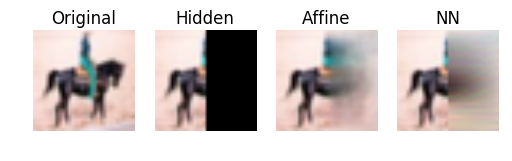

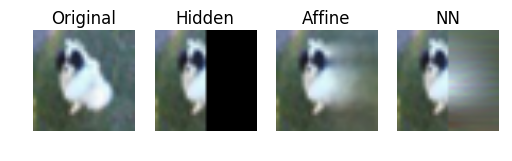

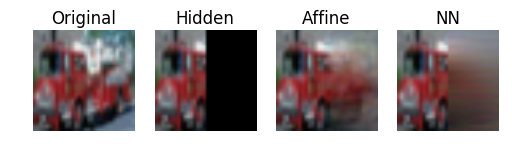

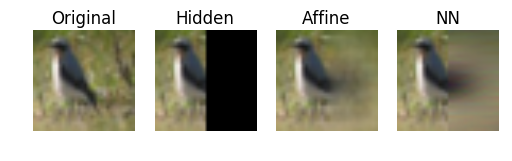

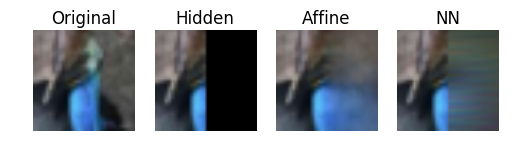

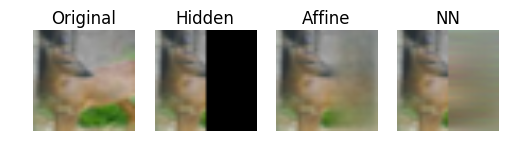

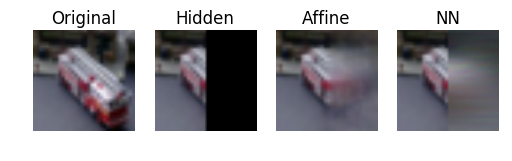

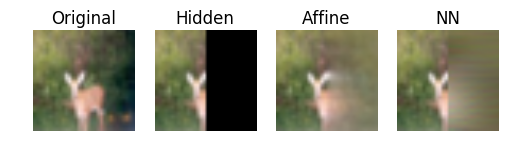

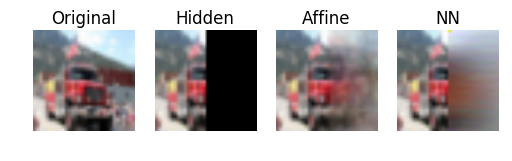

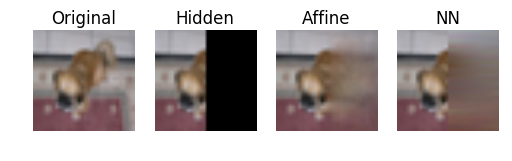

In [10]:
for i in range(10):
    random = np.random.randint(0, 50000)    

    # original image
    original = train[:, random]
    originalImg = convert_images(original)

    # hidden image
    hidden = train_hideRight[:, random]
    hiddenImg = convert_images(hidden)
    
    # approximated image
    approx = train_affine[:, random]
    approxImg = convert_images(approx)
    
    # nn image
    nn = train_nn[:, random]
    nnImg = convert_images(nn)
    
    # plot
    plt.figure(i); 
    plt.subplot(1, 4, 1); plt.imshow(originalImg[:, :, :, 0]); plt.title('Original'); plt.axis('off')
    plt.subplot(1, 4, 2); plt.imshow(hiddenImg[:, :, :, 0]); plt.title('Hidden'); plt.axis('off')
    plt.subplot(1, 4, 3); plt.imshow(approxImg[:, :, :, 0]); plt.title('Affine'); plt.axis('off')
    plt.subplot(1, 4, 4); plt.imshow(nnImg[:, :, :, 0]); plt.title('NN'); plt.axis('off')
    plt.savefig('cifar_gen_%d' %i)

In [ ]:
temp = predicted_test.T
print temp.shape

In [ ]:
plt.imshow(train_images[:, :, :, 5000])

In [ ]:
temp = train[:, 0]
temp1 = convert_images(temp)
temp2 = np.reshape(temp, (3072))
print temp[:1000] == temp2[:1000]

In [12]:
import scipy.stats as stats

k2, p = stats.normaltest(train[0, :].T)
print k2
print p

15744.0065911
0.0


In [5]:
print k2.shape
print p.shape

(3072,)
(3072,)


In [11]:
print np.min(p)

0.0


In [24]:
counter = 0
for i in range(3072):
    if p[i] > 0.01:
        counter += 1
print counter

0


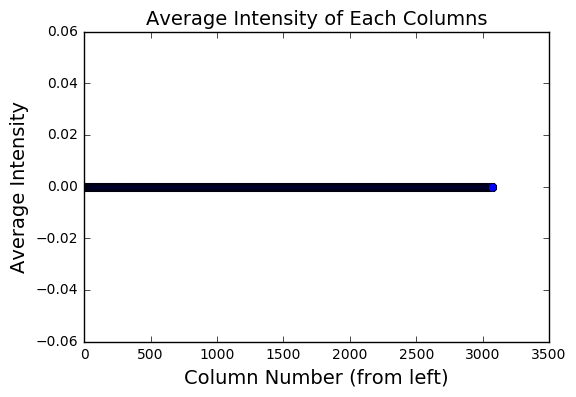

In [26]:
fig, ax = plt.subplots()
plt.figure(1)

numPts = np.arange(0, 3072)

plt.plot(numPts, p, '-o', c='b')

plt.title("Average Intensity of Each Columns", fontsize=14)
plt.ylabel("Average Intensity", fontsize=14)
plt.xlabel("Column Number (from left)", fontsize=14)
